In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
from tensorflow.keras import layers, activations, losses, optimizers
from tensorflow.keras.models import Model

In [2]:
def vec_product(v1, v2):
    return v1[0]*v2[1] - v1[1]*v2[0]


def in_rectangle(a, b, c, d, dot):
    v1, v2, v3, v4 = a-dot, b-dot, c-dot, d-dot
    return vec_product(v1, v2) <= 0 and vec_product(v2, v3) <= 0 and \
            vec_product(v3, v4) <= 0 and vec_product(v4, v1) <= 0


def draw_rectangle(X, coordinate_x, coordinate_y, length, width, angle, colour, need_noise, noise):
    side = X.shape[0]
    rotation_matrix = np.asmatrix(np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]))
    
    # initialize
    a = np.array([0., 0.])
    b = np.array([length*1., 0.])
    c = np.array([length*1., width*1.])
    d = np.array([0., width*1.])
    
    # rotate
    a = np.resize((rotation_matrix @ a), (2,))
    b = np.resize((rotation_matrix @ b), (2,))
    c = np.resize((rotation_matrix @ c), (2,))
    d = np.resize((rotation_matrix @ d), (2,))
    
    # move to the first quadrant
    min_coord = np.amin([a, b, c, d], axis=0)
    a -= min_coord
    b -= min_coord
    c -= min_coord
    d -= min_coord

    # cast to integer
    a = a.astype(np.int64)
    b = b.astype(np.int64)
    c = c.astype(np.int64)
    d = d.astype(np.int64)
    
    # shift
    a[0] += coordinate_x
    a[1] = coordinate_y - a[1]
    b[0] += coordinate_x
    b[1] = coordinate_y - b[1]
    c[0] += coordinate_x
    c[1] = coordinate_y - c[1]
    d[0] += coordinate_x
    d[1] = coordinate_y - d[1]
    
    # clip
    a = np.clip(a, 0, side-1)
    b = np.clip(b, 0, side-1)
    c = np.clip(c, 0, side-1)
    d = np.clip(d, 0, side-1)
    
    # max/min
    max_coord = np.amax([a, b, c, d], axis=0)
    min_coord = np.amin([a, b, c, d], axis=0)
    area = (max_coord[0]-min_coord[0]+1)*(max_coord[1]-min_coord[1]+1)
    
    # draw
    for x in range(min_coord[0], max_coord[0]+1):
        for y in range(min_coord[1], max_coord[1]+1):
            if in_rectangle(a, b, c, d, np.array([x, y])):
                X[y, x] = colour
                if need_noise:
                    noise[y, x] = colour
    
    return X, area, noise

In [3]:
def independent_noise(X, percentage, length_boundary, width_coef, colour, need_noise=False):
    noise = []
    if need_noise:
        noise = np.zeros(X.shape)
    side = X.shape[0]
    noise_area = 0
    while noise_area/(side**2) < percentage:
        length = np.random.randint(3, length_boundary)
        width = int(width_coef*length)
        angle = np.random.rand(1)*np.pi
        bound = np.maximum(length, width)
        coordinates = np.random.randint(0, side-bound, 2)
        X, area, noise = draw_rectangle(X, coordinates[0], coordinates[1]+bound, 
                                 length, width, angle, colour, need_noise, noise)
        noise_area += area
    return X, noise

In [4]:
def dependent_noise(X, percentage, window, colour, need_noise=False):
    noise = []
    if need_noise:
        noise = np.zeros(X.shape)
    side = X.shape[0]
    angles = [np.pi/6, 5*np.pi/6, np.pi/4, 3*np.pi/4, np.pi/3, 2*np.pi/3, np.pi/2, np.pi]
    noise_area = 0
    rounds = 0
    max_rounds = 1000 # maximum number of loops
    while noise_area/(side**2) < percentage and rounds < max_rounds:
        rounds += 1
        # indicates that line suits
        suit = False
        # generate coordinates
        coordinates = np.random.randint(0, side-window, 2)
        # generate angles
        np.random.shuffle(angles)
        # trying to cross the borders with lines with different angles
        for angle in angles:
            # make line
            tan = np.tan(angle)
            cotan = np.tan(np.pi/2 - angle)
            if np.abs(tan) <= 1:
                x = np.arange(-window//2, window//2)
                y = x * tan
                mask = (y > -window/2.) & (y < window/2.)
            else:
                y = np.arange(-window//2, window//2)
                x = y * cotan
                mask = (x > -window/2.) & (x < window/2.)
            # shift with window
            x = np.clip(x + window//2, 0, window - 1)
            y = np.clip(window//2 - y, 0, window - 1)
            # shift with coordinates
            x = np.clip(x + coordinates[0], 0, side - 1)
            y = np.clip(y + coordinates[1], 0, side - 1)
            I = y[mask].astype(np.int64)
            J = x[mask].astype(np.int64)
            # check for crossing
            previous = 0
            cross = 0
            for itr, (i, j) in enumerate(zip(I, J)):
                if itr != 0:
                    if cross == 0 and previous >= colour*0.25 and colour*0.75 >= X[i,j]:
                        cross += 1
                    elif cross > 0 and previous <= colour*0.25 and colour*0.75 <= X[i,j]:
                        suit = True
                        break
                previous = X[i,j]
            # if line suits, draw it
            if suit:
                sin = np.sin(angle)
                cos = abs(np.cos(angle))
                if np.abs(tan) <= 1:
                    length = int(window/abs(np.cos(angle)))
                else:
                    length = int(window/np.sin(angle))
                width = length//2
                coordinates[0] += window//2
                coordinates[0] -= int(cos*length/2+(cos**2)*sin*width)
                coordinates[1] += window//2
                coordinates[1] += int(sin*length/2+(sin**2)*cos*width)
                X, area, noise = draw_rectangle(X, coordinates[0], coordinates[1], 
                                                length, width, angle, colour, 
                                                need_noise, noise)
                noise_area += area
                break
    return X, noise

In [5]:
def data_loader(file_name, dataset_name_list, batch_size, noise_mode):        
    for dataset_name in dataset_name_list:
        with h5py.File(file_name, 'r') as f:
            dataset_length = f[dataset_name].shape[0]
        current_index = 0
        next_index = 0
        while current_index < dataset_length:
            next_index = min(current_index+batch_size, dataset_length)
            with h5py.File(file_name, 'r') as f:
                im_batch = f[dataset_name][current_index : next_index]/255.
            if noise_mode == 'dependent':
                for i in range(next_index-current_index):
                    im_batch[i] = dependent_noise(im_batch[i], percentage=0.2, window=30, colour=1.)[0]
            else:
                for i in range(next_index-current_index):
                    im_batch[i] = independent_noise(im_batch[i], percentage=0.2, 
                                                    length_boundary=30, width_coef=0.5, colour=1.)[0]
            im_batch = tf.convert_to_tensor(im_batch, dtype=tf.float32)
            im_batch = im_batch[..., tf.newaxis]
            with h5py.File(file_name, 'r') as f:
                gt_batch = f[dataset_name][current_index : next_index]/255.
            gt_batch = tf.convert_to_tensor(gt_batch, dtype=tf.float32)
            gt_batch = gt_batch[..., tf.newaxis]
            yield (im_batch, gt_batch)
            current_index = next_index
            

file_name = 'isbi12_data.hdf5'
train_data_set_list = ['augmented/tile/train', 'augmented/random/train']
test_data_set_list = ['augmented/tile/test', 'augmented/random/test']
noise_mode = 'independent'

In [6]:
class denoising_autoencoder(Model):
    def __init__(self, dim, first_dense_layer, second_dense_layer):
        super(denoising_autoencoder, self).__init__()
        
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(dim, dim, 1)),
            layers.Conv2D(4, (3, 3), activation='relu'), 
            layers.Conv2D(8, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(first_dense_layer, activation='relu'),
            layers.Dense(second_dense_layer, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(first_dense_layer, activation='relu'),
            layers.Dense(8*(dim-4)**2, activation='relu'),
            layers.Reshape((dim-4, dim-4, 8)),
            layers.Conv2DTranspose(4, (3,3), activation='relu'),
            layers.Conv2DTranspose(1, (3,3), activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = denoising_autoencoder(128, 2**8, 2**6)

In [7]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 4)       40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 8)       296       
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               31490304  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
Total params: 31,507,088
Trainable params: 31,507,088
Non-trainable params: 0
_________________________________________________________________


In [8]:
loss_function = losses.MeanSquaredError()
optimizer = optimizers.Adam()

In [9]:
def train_epoch(model, file_name, dataset_name_list, batch_size, noise_mode, loss_fn, opt):
    train_loss = []
    index = 0
    for image_batch, gt_batch in data_loader(file_name, dataset_name_list, batch_size, noise_mode):
        with tf.GradientTape() as tape:
            reconstructed_images = model(image_batch)
            loss = loss_fn(reconstructed_images, gt_batch)
            gradients = tape.gradient(loss, model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)
        train_loss.append(loss)
        print('\t partial train loss (single batch %d): %f' % (index, loss))
        index += 1
    return tf.reduce_mean(train_loss).numpy()

In [10]:
def test_epoch(model, file_name, dataset_name_list, batch_size, noise_mode, loss_fn):
    reconstructed = []
    ground_truth = []
    for image_batch, gt_batch in data_loader(file_name, dataset_name_list, batch_size, noise_mode):
        reconstructed_images = model(image_batch)
        reconstructed.append(reconstructed_images)
        ground_truth.append(gt_batch)
    reconstructed = tf.concat(reconstructed, axis=0)
    ground_truth = tf.concat(ground_truth, axis=0)
    test_loss = loss_fn(reconstructed, ground_truth)
    return test_loss.numpy()

In [11]:
def plot_outputs(model, file_name, dataset_name_list, noise_mode, n=5):
    plt.figure(figsize=(10, 5))
    index = 0
    for im, gt in data_loader(file_name, dataset_name_list, 1, noise_mode):
        if index >= n:
            break
        ax = plt.subplot(3, n, index + 1)
        reconstructed = model(im)
        plt.imshow(tf.squeeze(gt).numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if index == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(3, n, index + 1 + n)
        plt.imshow(tf.squeeze(im).numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if index == n//2:
            ax.set_title('Images with topological noise')
        ax = plt.subplot(3, n, index + 1 + n + n)
        plt.imshow(tf.squeeze(reconstructed).numpy(), cmap='gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if index == n//2:
            ax.set_title('Denoised images')
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1, 
                    top=1, 
                    wspace=0.3, 
                    hspace=0.3)     
        index += 1
    plt.show()

EPOCH 1/30
	 partial train loss (single batch 0): 0.245009
	 partial train loss (single batch 1): 0.244808
	 partial train loss (single batch 2): 0.244558
	 partial train loss (single batch 3): 0.244364
	 partial train loss (single batch 4): 0.242375
	 partial train loss (single batch 5): 0.237506
	 partial train loss (single batch 6): 0.228191
	 partial train loss (single batch 7): 0.213732
	 partial train loss (single batch 8): 0.204371
	 partial train loss (single batch 9): 0.202180
	 partial train loss (single batch 10): 0.179591
	 partial train loss (single batch 11): 0.206726
	 partial train loss (single batch 12): 0.177142
	 partial train loss (single batch 13): 0.171280
	 partial train loss (single batch 14): 0.205751
	 partial train loss (single batch 15): 0.181683
	 partial train loss (single batch 16): 0.180471
	 partial train loss (single batch 17): 0.171753
	 partial train loss (single batch 18): 0.195920
	 partial train loss (single batch 19): 0.198581
	 partial train los

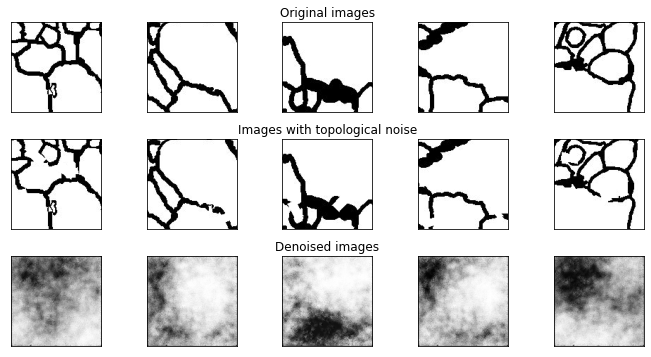

EPOCH 2/30
	 partial train loss (single batch 0): 0.148300
	 partial train loss (single batch 1): 0.147732
	 partial train loss (single batch 2): 0.152543
	 partial train loss (single batch 3): 0.137921
	 partial train loss (single batch 4): 0.143064
	 partial train loss (single batch 5): 0.150541
	 partial train loss (single batch 6): 0.160734
	 partial train loss (single batch 7): 0.149448
	 partial train loss (single batch 8): 0.167095
	 partial train loss (single batch 9): 0.160780
	 partial train loss (single batch 10): 0.141044
	 partial train loss (single batch 11): 0.166582
	 partial train loss (single batch 12): 0.147204
	 partial train loss (single batch 13): 0.140554
	 partial train loss (single batch 14): 0.162961
	 partial train loss (single batch 15): 0.151917
	 partial train loss (single batch 16): 0.152410
	 partial train loss (single batch 17): 0.138349
	 partial train loss (single batch 18): 0.170399
	 partial train loss (single batch 19): 0.176670
	 partial train los

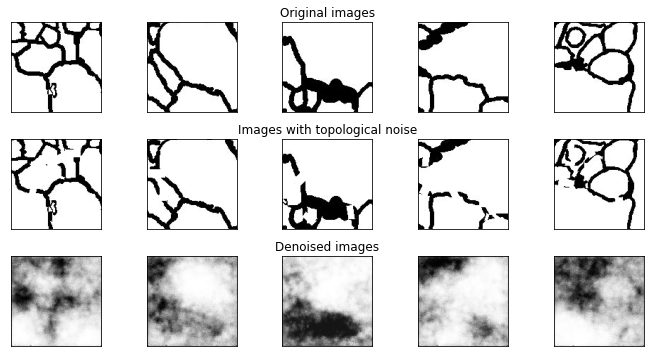

EPOCH 3/30
	 partial train loss (single batch 0): 0.140049
	 partial train loss (single batch 1): 0.139530
	 partial train loss (single batch 2): 0.144639
	 partial train loss (single batch 3): 0.131392
	 partial train loss (single batch 4): 0.135142
	 partial train loss (single batch 5): 0.140007
	 partial train loss (single batch 6): 0.151828
	 partial train loss (single batch 7): 0.139204
	 partial train loss (single batch 8): 0.157957
	 partial train loss (single batch 9): 0.149891
	 partial train loss (single batch 10): 0.133644
	 partial train loss (single batch 11): 0.156245
	 partial train loss (single batch 12): 0.140059
	 partial train loss (single batch 13): 0.131580
	 partial train loss (single batch 14): 0.156237
	 partial train loss (single batch 15): 0.143863
	 partial train loss (single batch 16): 0.143367
	 partial train loss (single batch 17): 0.128554
	 partial train loss (single batch 18): 0.160484
	 partial train loss (single batch 19): 0.168427
	 partial train los

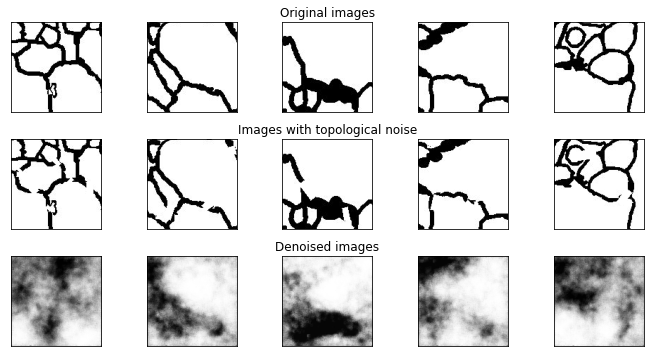

EPOCH 4/30
	 partial train loss (single batch 0): 0.134097
	 partial train loss (single batch 1): 0.135061
	 partial train loss (single batch 2): 0.140676
	 partial train loss (single batch 3): 0.127315
	 partial train loss (single batch 4): 0.128634
	 partial train loss (single batch 5): 0.136511
	 partial train loss (single batch 6): 0.146268
	 partial train loss (single batch 7): 0.135136
	 partial train loss (single batch 8): 0.153822
	 partial train loss (single batch 9): 0.143847
	 partial train loss (single batch 10): 0.127168
	 partial train loss (single batch 11): 0.149642
	 partial train loss (single batch 12): 0.134274
	 partial train loss (single batch 13): 0.125695
	 partial train loss (single batch 14): 0.148771
	 partial train loss (single batch 15): 0.138183
	 partial train loss (single batch 16): 0.138016
	 partial train loss (single batch 17): 0.122466
	 partial train loss (single batch 18): 0.155084
	 partial train loss (single batch 19): 0.161856
	 partial train los

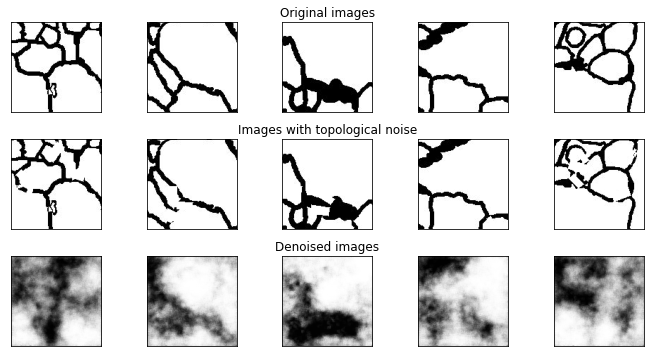

EPOCH 5/30
	 partial train loss (single batch 0): 0.130793
	 partial train loss (single batch 1): 0.132555
	 partial train loss (single batch 2): 0.137047
	 partial train loss (single batch 3): 0.124867
	 partial train loss (single batch 4): 0.125699
	 partial train loss (single batch 5): 0.132198
	 partial train loss (single batch 6): 0.141320
	 partial train loss (single batch 7): 0.131593
	 partial train loss (single batch 8): 0.151220
	 partial train loss (single batch 9): 0.140370
	 partial train loss (single batch 10): 0.125318
	 partial train loss (single batch 11): 0.144063
	 partial train loss (single batch 12): 0.131548
	 partial train loss (single batch 13): 0.120570
	 partial train loss (single batch 14): 0.145986
	 partial train loss (single batch 15): 0.135801
	 partial train loss (single batch 16): 0.135974
	 partial train loss (single batch 17): 0.118034
	 partial train loss (single batch 18): 0.149273
	 partial train loss (single batch 19): 0.157280
	 partial train los

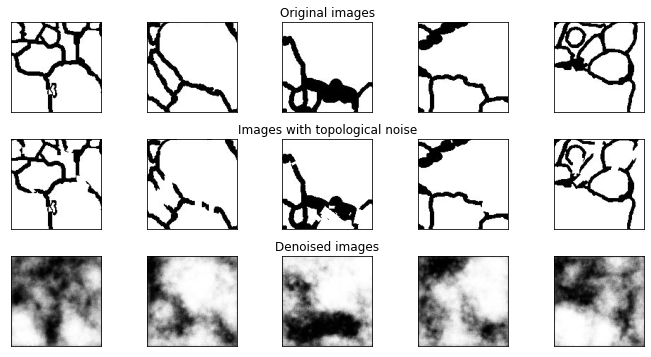

EPOCH 6/30
	 partial train loss (single batch 0): 0.128205
	 partial train loss (single batch 1): 0.130165
	 partial train loss (single batch 2): 0.133248
	 partial train loss (single batch 3): 0.122814
	 partial train loss (single batch 4): 0.124297
	 partial train loss (single batch 5): 0.129940
	 partial train loss (single batch 6): 0.137934
	 partial train loss (single batch 7): 0.127714
	 partial train loss (single batch 8): 0.147687
	 partial train loss (single batch 9): 0.135714
	 partial train loss (single batch 10): 0.125344
	 partial train loss (single batch 11): 0.141371
	 partial train loss (single batch 12): 0.130269
	 partial train loss (single batch 13): 0.118313
	 partial train loss (single batch 14): 0.144710
	 partial train loss (single batch 15): 0.132800
	 partial train loss (single batch 16): 0.131949
	 partial train loss (single batch 17): 0.113773
	 partial train loss (single batch 18): 0.147622
	 partial train loss (single batch 19): 0.157048
	 partial train los

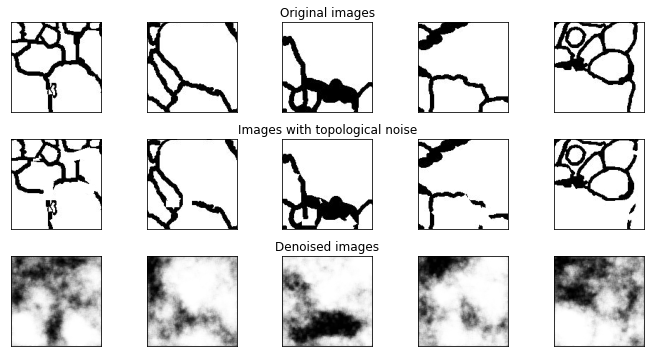

EPOCH 7/30
	 partial train loss (single batch 0): 0.127335
	 partial train loss (single batch 1): 0.128702
	 partial train loss (single batch 2): 0.130257
	 partial train loss (single batch 3): 0.119236
	 partial train loss (single batch 4): 0.119195
	 partial train loss (single batch 5): 0.127222
	 partial train loss (single batch 6): 0.135882
	 partial train loss (single batch 7): 0.124249
	 partial train loss (single batch 8): 0.147660
	 partial train loss (single batch 9): 0.130536
	 partial train loss (single batch 10): 0.120581
	 partial train loss (single batch 11): 0.138158
	 partial train loss (single batch 12): 0.126894
	 partial train loss (single batch 13): 0.115054
	 partial train loss (single batch 14): 0.139751
	 partial train loss (single batch 15): 0.129891
	 partial train loss (single batch 16): 0.130629
	 partial train loss (single batch 17): 0.112197
	 partial train loss (single batch 18): 0.142731
	 partial train loss (single batch 19): 0.154005
	 partial train los

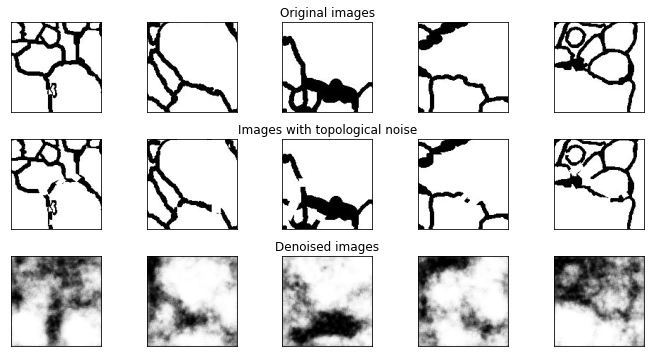

EPOCH 8/30
	 partial train loss (single batch 0): 0.122393
	 partial train loss (single batch 1): 0.126255
	 partial train loss (single batch 2): 0.130589
	 partial train loss (single batch 3): 0.116410
	 partial train loss (single batch 4): 0.117639
	 partial train loss (single batch 5): 0.125560
	 partial train loss (single batch 6): 0.131425
	 partial train loss (single batch 7): 0.120801
	 partial train loss (single batch 8): 0.142659
	 partial train loss (single batch 9): 0.126201
	 partial train loss (single batch 10): 0.118062
	 partial train loss (single batch 11): 0.134822
	 partial train loss (single batch 12): 0.127154
	 partial train loss (single batch 13): 0.114264
	 partial train loss (single batch 14): 0.138824
	 partial train loss (single batch 15): 0.126437
	 partial train loss (single batch 16): 0.127909
	 partial train loss (single batch 17): 0.108916
	 partial train loss (single batch 18): 0.140316
	 partial train loss (single batch 19): 0.150239
	 partial train los

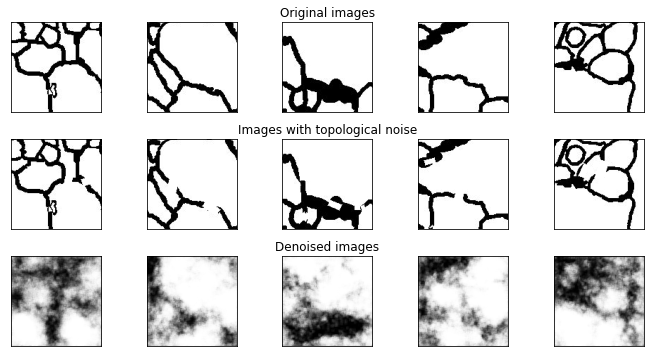

EPOCH 9/30
	 partial train loss (single batch 0): 0.119496
	 partial train loss (single batch 1): 0.121449
	 partial train loss (single batch 2): 0.125649
	 partial train loss (single batch 3): 0.113436
	 partial train loss (single batch 4): 0.115118
	 partial train loss (single batch 5): 0.122412
	 partial train loss (single batch 6): 0.129540
	 partial train loss (single batch 7): 0.119722
	 partial train loss (single batch 8): 0.141635
	 partial train loss (single batch 9): 0.124083
	 partial train loss (single batch 10): 0.115761
	 partial train loss (single batch 11): 0.131907
	 partial train loss (single batch 12): 0.121625
	 partial train loss (single batch 13): 0.111127
	 partial train loss (single batch 14): 0.135622
	 partial train loss (single batch 15): 0.123316
	 partial train loss (single batch 16): 0.126792
	 partial train loss (single batch 17): 0.106152
	 partial train loss (single batch 18): 0.136479
	 partial train loss (single batch 19): 0.147636
	 partial train los

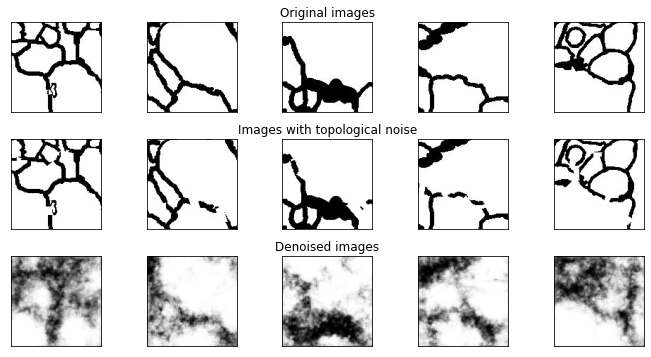

EPOCH 10/30
	 partial train loss (single batch 0): 0.118078
	 partial train loss (single batch 1): 0.119328
	 partial train loss (single batch 2): 0.123503
	 partial train loss (single batch 3): 0.110985
	 partial train loss (single batch 4): 0.114166
	 partial train loss (single batch 5): 0.121904
	 partial train loss (single batch 6): 0.127946
	 partial train loss (single batch 7): 0.117634
	 partial train loss (single batch 8): 0.140084
	 partial train loss (single batch 9): 0.122410
	 partial train loss (single batch 10): 0.113186
	 partial train loss (single batch 11): 0.130283
	 partial train loss (single batch 12): 0.121931
	 partial train loss (single batch 13): 0.107781
	 partial train loss (single batch 14): 0.131866
	 partial train loss (single batch 15): 0.121595
	 partial train loss (single batch 16): 0.123458
	 partial train loss (single batch 17): 0.101802
	 partial train loss (single batch 18): 0.132731
	 partial train loss (single batch 19): 0.145349
	 partial train lo

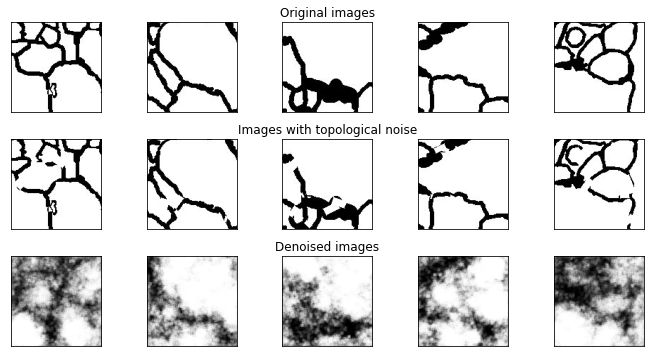

EPOCH 11/30
	 partial train loss (single batch 0): 0.117150
	 partial train loss (single batch 1): 0.117455
	 partial train loss (single batch 2): 0.119880
	 partial train loss (single batch 3): 0.109478
	 partial train loss (single batch 4): 0.111410
	 partial train loss (single batch 5): 0.115970
	 partial train loss (single batch 6): 0.123320
	 partial train loss (single batch 7): 0.113913
	 partial train loss (single batch 8): 0.134162
	 partial train loss (single batch 9): 0.116259
	 partial train loss (single batch 10): 0.108307
	 partial train loss (single batch 11): 0.125051
	 partial train loss (single batch 12): 0.117533
	 partial train loss (single batch 13): 0.104700
	 partial train loss (single batch 14): 0.130283
	 partial train loss (single batch 15): 0.120730
	 partial train loss (single batch 16): 0.122408
	 partial train loss (single batch 17): 0.101032
	 partial train loss (single batch 18): 0.129715
	 partial train loss (single batch 19): 0.141970
	 partial train lo

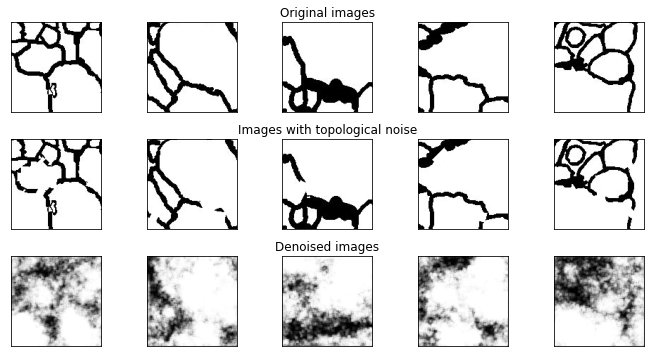

EPOCH 12/30
	 partial train loss (single batch 0): 0.113568
	 partial train loss (single batch 1): 0.112589
	 partial train loss (single batch 2): 0.116872
	 partial train loss (single batch 3): 0.105585
	 partial train loss (single batch 4): 0.107640
	 partial train loss (single batch 5): 0.113873
	 partial train loss (single batch 6): 0.121072
	 partial train loss (single batch 7): 0.111715
	 partial train loss (single batch 8): 0.132154
	 partial train loss (single batch 9): 0.113550
	 partial train loss (single batch 10): 0.106612
	 partial train loss (single batch 11): 0.120863
	 partial train loss (single batch 12): 0.113794
	 partial train loss (single batch 13): 0.100135
	 partial train loss (single batch 14): 0.124379
	 partial train loss (single batch 15): 0.118168
	 partial train loss (single batch 16): 0.119216
	 partial train loss (single batch 17): 0.094676
	 partial train loss (single batch 18): 0.127037
	 partial train loss (single batch 19): 0.137314
	 partial train lo

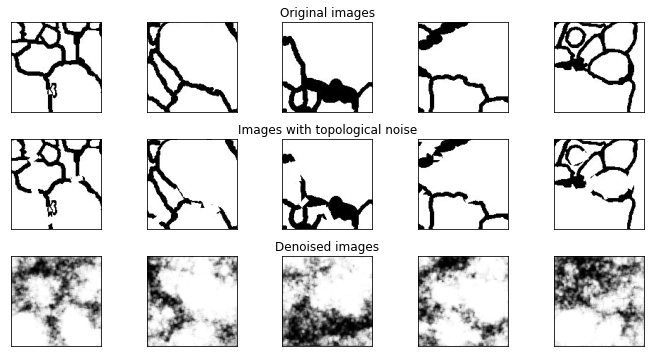

EPOCH 13/30
	 partial train loss (single batch 0): 0.112684
	 partial train loss (single batch 1): 0.112913
	 partial train loss (single batch 2): 0.117261
	 partial train loss (single batch 3): 0.105844
	 partial train loss (single batch 4): 0.107662
	 partial train loss (single batch 5): 0.110691
	 partial train loss (single batch 6): 0.116088
	 partial train loss (single batch 7): 0.106378
	 partial train loss (single batch 8): 0.126933
	 partial train loss (single batch 9): 0.110295
	 partial train loss (single batch 10): 0.104211
	 partial train loss (single batch 11): 0.120884
	 partial train loss (single batch 12): 0.113951
	 partial train loss (single batch 13): 0.100570
	 partial train loss (single batch 14): 0.118615
	 partial train loss (single batch 15): 0.113686
	 partial train loss (single batch 16): 0.116061
	 partial train loss (single batch 17): 0.094350
	 partial train loss (single batch 18): 0.124918
	 partial train loss (single batch 19): 0.135257
	 partial train lo

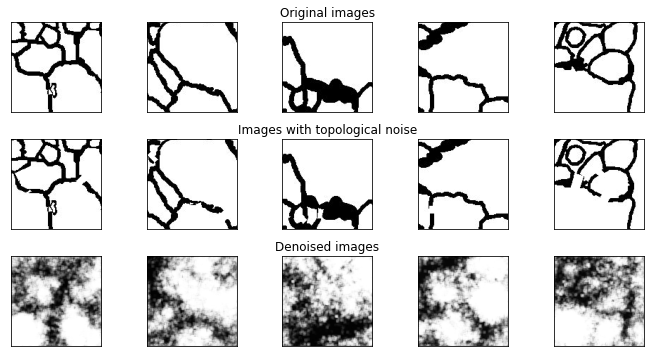

EPOCH 14/30
	 partial train loss (single batch 0): 0.112864
	 partial train loss (single batch 1): 0.113432
	 partial train loss (single batch 2): 0.116120
	 partial train loss (single batch 3): 0.103730
	 partial train loss (single batch 4): 0.104816
	 partial train loss (single batch 5): 0.107519
	 partial train loss (single batch 6): 0.114774
	 partial train loss (single batch 7): 0.107647
	 partial train loss (single batch 8): 0.128694
	 partial train loss (single batch 9): 0.110561
	 partial train loss (single batch 10): 0.097667
	 partial train loss (single batch 11): 0.112036
	 partial train loss (single batch 12): 0.105573
	 partial train loss (single batch 13): 0.091940
	 partial train loss (single batch 14): 0.112854
	 partial train loss (single batch 15): 0.109930
	 partial train loss (single batch 16): 0.113819
	 partial train loss (single batch 17): 0.092937
	 partial train loss (single batch 18): 0.120978
	 partial train loss (single batch 19): 0.132762
	 partial train lo

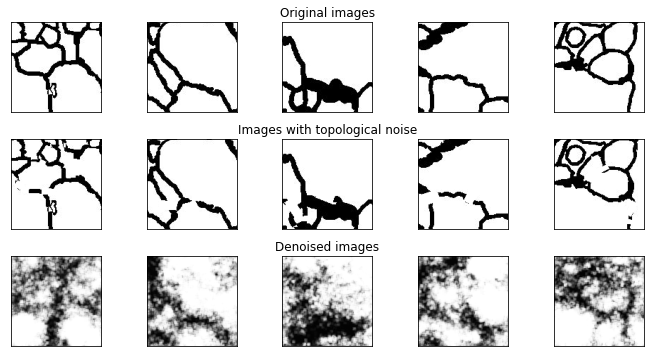

EPOCH 15/30
	 partial train loss (single batch 0): 0.107503
	 partial train loss (single batch 1): 0.108537
	 partial train loss (single batch 2): 0.115818
	 partial train loss (single batch 3): 0.103082
	 partial train loss (single batch 4): 0.102286
	 partial train loss (single batch 5): 0.104759
	 partial train loss (single batch 6): 0.111291
	 partial train loss (single batch 7): 0.101954
	 partial train loss (single batch 8): 0.121380
	 partial train loss (single batch 9): 0.102273
	 partial train loss (single batch 10): 0.100320
	 partial train loss (single batch 11): 0.113614
	 partial train loss (single batch 12): 0.108439
	 partial train loss (single batch 13): 0.094443
	 partial train loss (single batch 14): 0.114941
	 partial train loss (single batch 15): 0.103172
	 partial train loss (single batch 16): 0.107992
	 partial train loss (single batch 17): 0.084238
	 partial train loss (single batch 18): 0.112106
	 partial train loss (single batch 19): 0.125194
	 partial train lo

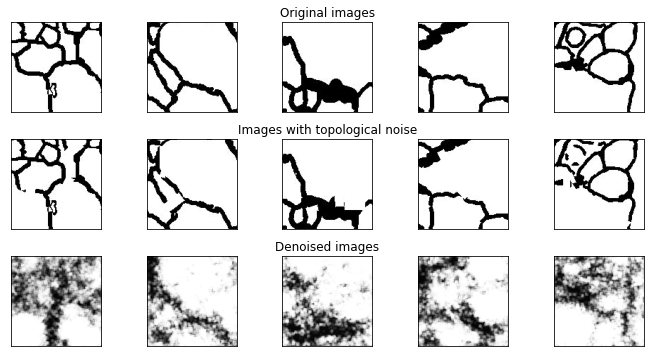

EPOCH 16/30
	 partial train loss (single batch 0): 0.101857
	 partial train loss (single batch 1): 0.102803
	 partial train loss (single batch 2): 0.113073
	 partial train loss (single batch 3): 0.098569
	 partial train loss (single batch 4): 0.099018
	 partial train loss (single batch 5): 0.102084
	 partial train loss (single batch 6): 0.111933
	 partial train loss (single batch 7): 0.100882
	 partial train loss (single batch 8): 0.120319
	 partial train loss (single batch 9): 0.103956
	 partial train loss (single batch 10): 0.094841
	 partial train loss (single batch 11): 0.103125
	 partial train loss (single batch 12): 0.103081
	 partial train loss (single batch 13): 0.087914
	 partial train loss (single batch 14): 0.112404
	 partial train loss (single batch 15): 0.105428
	 partial train loss (single batch 16): 0.109671
	 partial train loss (single batch 17): 0.085561
	 partial train loss (single batch 18): 0.114328
	 partial train loss (single batch 19): 0.121841
	 partial train lo

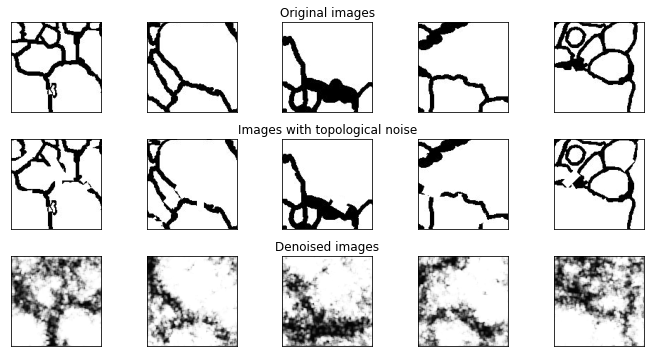

EPOCH 17/30
	 partial train loss (single batch 0): 0.097495
	 partial train loss (single batch 1): 0.100133
	 partial train loss (single batch 2): 0.104177
	 partial train loss (single batch 3): 0.093730
	 partial train loss (single batch 4): 0.089497
	 partial train loss (single batch 5): 0.096118
	 partial train loss (single batch 6): 0.099675
	 partial train loss (single batch 7): 0.094911
	 partial train loss (single batch 8): 0.113577
	 partial train loss (single batch 9): 0.100781
	 partial train loss (single batch 10): 0.092205
	 partial train loss (single batch 11): 0.106986
	 partial train loss (single batch 12): 0.101406
	 partial train loss (single batch 13): 0.087180
	 partial train loss (single batch 14): 0.109245
	 partial train loss (single batch 15): 0.101981
	 partial train loss (single batch 16): 0.105555
	 partial train loss (single batch 17): 0.087300
	 partial train loss (single batch 18): 0.109377
	 partial train loss (single batch 19): 0.118483
	 partial train lo

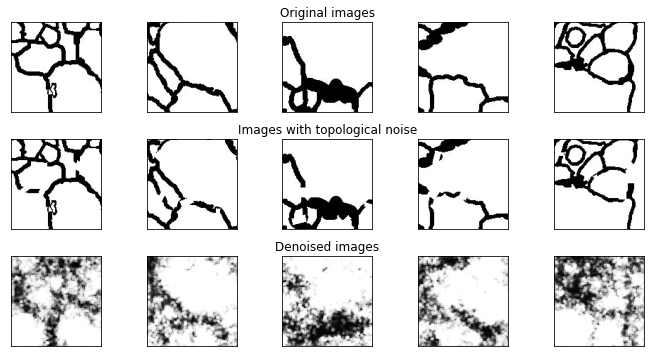

EPOCH 18/30
	 partial train loss (single batch 0): 0.092898
	 partial train loss (single batch 1): 0.095022
	 partial train loss (single batch 2): 0.101110
	 partial train loss (single batch 3): 0.088863
	 partial train loss (single batch 4): 0.089466
	 partial train loss (single batch 5): 0.093950
	 partial train loss (single batch 6): 0.098828
	 partial train loss (single batch 7): 0.089844
	 partial train loss (single batch 8): 0.108663
	 partial train loss (single batch 9): 0.090574
	 partial train loss (single batch 10): 0.087690
	 partial train loss (single batch 11): 0.094726
	 partial train loss (single batch 12): 0.096668
	 partial train loss (single batch 13): 0.081474
	 partial train loss (single batch 14): 0.100960
	 partial train loss (single batch 15): 0.096516
	 partial train loss (single batch 16): 0.105070
	 partial train loss (single batch 17): 0.084678
	 partial train loss (single batch 18): 0.113316
	 partial train loss (single batch 19): 0.115260
	 partial train lo

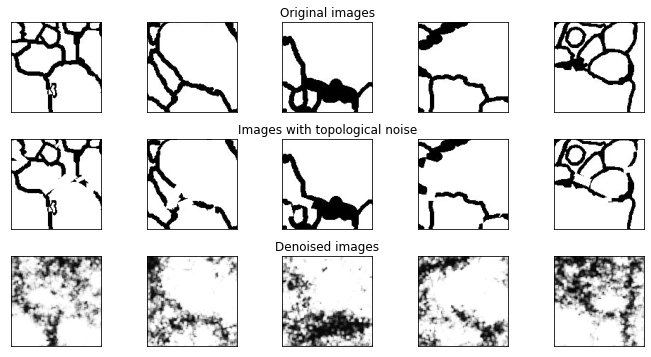

EPOCH 19/30
	 partial train loss (single batch 0): 0.091928
	 partial train loss (single batch 1): 0.090818
	 partial train loss (single batch 2): 0.094108
	 partial train loss (single batch 3): 0.084612
	 partial train loss (single batch 4): 0.086572
	 partial train loss (single batch 5): 0.086220
	 partial train loss (single batch 6): 0.092756
	 partial train loss (single batch 7): 0.088747
	 partial train loss (single batch 8): 0.104308
	 partial train loss (single batch 9): 0.092890
	 partial train loss (single batch 10): 0.085592
	 partial train loss (single batch 11): 0.088558
	 partial train loss (single batch 12): 0.088998
	 partial train loss (single batch 13): 0.076848
	 partial train loss (single batch 14): 0.092311
	 partial train loss (single batch 15): 0.093473
	 partial train loss (single batch 16): 0.093496
	 partial train loss (single batch 17): 0.076792
	 partial train loss (single batch 18): 0.100877
	 partial train loss (single batch 19): 0.107588
	 partial train lo

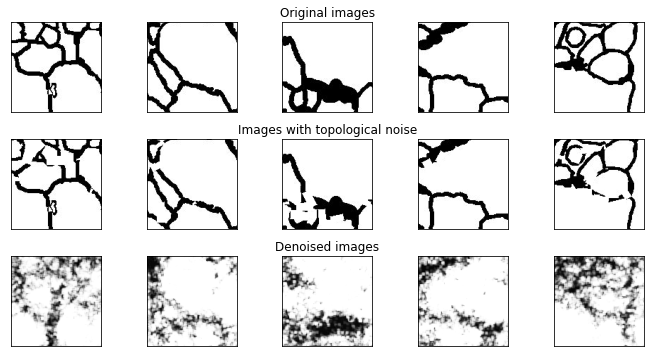

EPOCH 20/30
	 partial train loss (single batch 0): 0.096278
	 partial train loss (single batch 1): 0.095140
	 partial train loss (single batch 2): 0.103052
	 partial train loss (single batch 3): 0.090579
	 partial train loss (single batch 4): 0.086795
	 partial train loss (single batch 5): 0.089078
	 partial train loss (single batch 6): 0.088281
	 partial train loss (single batch 7): 0.085909
	 partial train loss (single batch 8): 0.104102
	 partial train loss (single batch 9): 0.087205
	 partial train loss (single batch 10): 0.081720
	 partial train loss (single batch 11): 0.086843
	 partial train loss (single batch 12): 0.088429
	 partial train loss (single batch 13): 0.072672
	 partial train loss (single batch 14): 0.089048
	 partial train loss (single batch 15): 0.086494
	 partial train loss (single batch 16): 0.088600
	 partial train loss (single batch 17): 0.080190
	 partial train loss (single batch 18): 0.102907
	 partial train loss (single batch 19): 0.105639
	 partial train lo

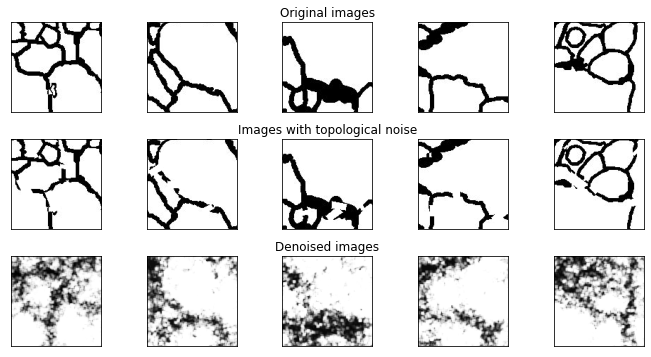

EPOCH 21/30
	 partial train loss (single batch 0): 0.083873
	 partial train loss (single batch 1): 0.088190
	 partial train loss (single batch 2): 0.098310
	 partial train loss (single batch 3): 0.086705
	 partial train loss (single batch 4): 0.082870
	 partial train loss (single batch 5): 0.087022
	 partial train loss (single batch 6): 0.086640
	 partial train loss (single batch 7): 0.088277
	 partial train loss (single batch 8): 0.102407
	 partial train loss (single batch 9): 0.088902
	 partial train loss (single batch 10): 0.079405


KeyboardInterrupt: 

In [12]:
history_da={'train_loss':[], 'test_loss':[]}
epochs = 30
batch_size = 10
for epoch in range(epochs):
    print('EPOCH %d/%d' % (epoch + 1, epochs))
    train_loss=train_epoch(
        model=autoencoder, 
        file_name=file_name,
        dataset_name_list=train_data_set_list,
        batch_size=batch_size,
        noise_mode=noise_mode,
        loss_fn=loss_function, 
        opt=optimizer)
    test_loss = test_epoch(
        model=autoencoder, 
        file_name=file_name,
        dataset_name_list=test_data_set_list,
        batch_size=batch_size,
        noise_mode=noise_mode,
        loss_fn=loss_function)
    history_da['train_loss'].append(train_loss)
    history_da['test_loss'].append(test_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t test loss {:.3f}'.format(epoch + 1, epochs, train_loss, test_loss))
    plot_outputs(autoencoder, file_name, test_data_set_list, noise_mode)

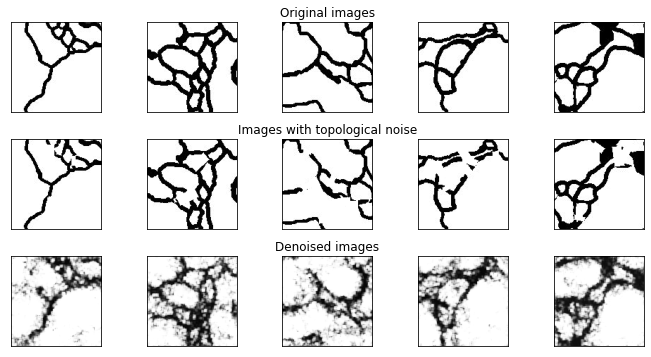

In [13]:
 plot_outputs(autoencoder, file_name, train_data_set_list, noise_mode)